# MNIST With SET
This is an example of training an SET network on the MNIST dataset using synapses, pytorch, and torchvision.

In [1]:
#Import torch libraries and get SETLayer from synapses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from synapses import SETLayer

#Some extras for visualizations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import seaborn as sns

from scipy.stats import chisquare

sns.set()

## SET Layer
The SET layer is a pytorch module that works with a similar API to a standard fully connected layer; to initialize, specify input and output dimensions.<br><br>
NOTE: one condition mentioned in the paper is that epsilon (a hyperparameter controlling layer sparsity) be much less than the input dimension and much less than the output dimension. The default value of epsilon is 11. Keep dimensions much bigger than epsilon! (epsilon can be passed in as an init argument to the layer).

In [2]:
#initialize the layer
sprs = SETLayer(128, 256)

#We can see the layer transforms inputs as we expect
inp = torch.randn((2, 128))
print('Input batch shape: ', tuple(inp.shape))
out = sprs(inp)
print('Output batch shape: ', tuple(out.shape))

Input batch shape:  (2, 128)
Output batch shape:  (2, 256)


In terms of behavior, the SETLayer transforms an input vector into the output space as would a fcl.
## Initial Connection Distribution
The intialized layer has randomly assigned connections between input nodes and output nodes; each connection is associated with a weight, drawn from a normal distribution.

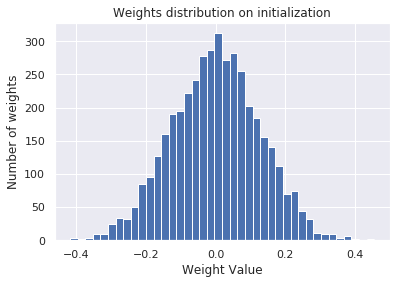

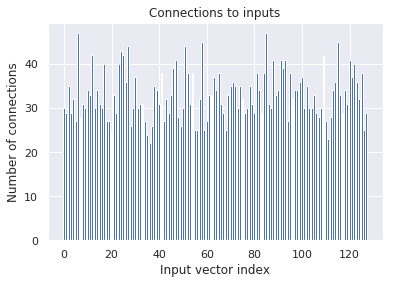

In [3]:
#Inspect init weight distribution
plt.hist(np.array(sprs.weight.data), bins=40)
plt.title('Weights distribution on initialization')
plt.xlabel('Weight Value')
plt.ylabel('Number of weights')
plt.show()

vec = sprs.connections[:, 0]
vec = np.array(vec)
values, counts = np.unique(vec, return_counts=True)
plt.title('Connections to inputs')
plt.bar(values, counts)
plt.xlabel('Input vector index')
plt.ylabel('Number of connections')
plt.show()

The weights are sampled from a normal distribution, as is done with a standard fcl. The connections to the inputs are uniformly distributed.<br><br>

## Killing Connections
When connections are reassigned in SET, some proportion (defined by hyperparameter zeta) of the weights closest to zero are removed. We can set these to zero using the zero_connections method on the layer. (This method leaves the connections unchanged.)

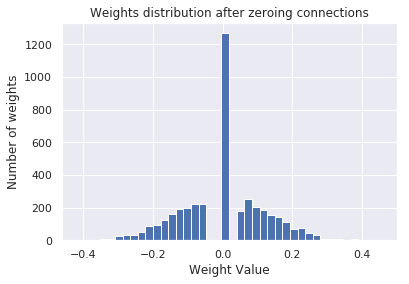

In [4]:
sprs.zero_connections()

#Inspect init weight distribution
plt.hist(np.array(sprs.weight.data), bins=40)
plt.title('Weights distribution after zeroing connections')
plt.xlabel('Weight Value')
plt.ylabel('Number of weights')
plt.show()

## Evolving Connections

The evolve_connections() method will reassign these weights to new connections between input and output nodes. By default, these weights are initialized by sampling from the same distribution as the init function. Optionally, these weights can be set at zero (with init=False argument).

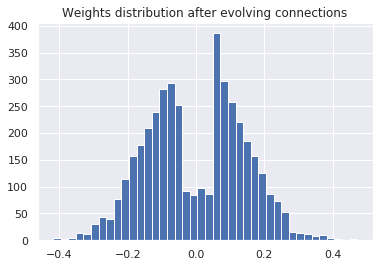

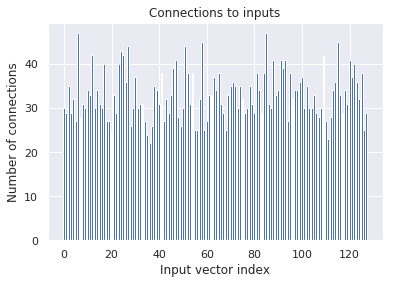

In [5]:
sprs.evolve_connections()

plt.hist(np.array(sprs.weight.data), bins=40)
plt.title('Weights distribution after evolving connections')
plt.show()

plt.title('Connections to inputs')
plt.bar(values, counts)
plt.xlabel('Input vector index')
plt.ylabel('Number of connections')
plt.show()

We can see these weight values have been re-distributed; the new connections conform to the same uniform distribution as before. (We see in the SET paper, and here later on, that the adaptive algorithm learns to allocate these connections to more important input values.)

## A Simple SET Model

The following is a simple sparsely-connected model using SETLayers with default hyperparameters.

In [6]:
class SparseNet(nn.Module):
    def __init__(self):
        super(SparseNet, self).__init__()
        self.set_layers = []
        self.set1 = SETLayer(784, 512)
        self.set_layers.append(self.set1)
        #self.set2 = SETLayer(512, 512)
        #self.set_layers.append(self.set2)
        self.set2 = SETLayer(512, 128)
        self.set_layers.append(self.set2)
        #Use a dense layer for output because of low output dimensionality
        self.fc1 = nn.Linear(128, 10)
        
    def zero_connections(self):
        """Sets connections to zero for inferences."""
        for layer in self.set_layers:
            layer.zero_connections()
        
    def evolve_connections(self):
        """Evolves connections."""
        for layer in self.set_layers:
            layer.evolve_connections()
        
    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.set1(x))
        x = F.relu(self.set2(x))
        #x = F.relu(self.set3(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
def count_params(model):

    prms = 0
    for parameter in model.parameters():
        n_params = 1
        for prm in parameter.shape:
            n_params *= prm
        prms += n_params

    return prms
    
device = "cpu"
sparse_net = SparseNet().to(device)
print('number of params: ', count_params(sparse_net))

number of params:  23226


Consider a fully-connected model with the same architecture: It would contain more than 20 times the number of parameters!<br>
## Training on MNIST
This code was adapted directly from the [pytorch mnist tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [7]:
class History(object):
    """Tracks and plots training history"""
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.p_value = []
        self.p_avg = []
        
    def add_p_value(self, p):
        mem = 10
        self.p_value.append(p)
        if len(self.p_value) < mem:
            new_avg = sum(self.p_value)/len(self.p_value)
        else:
            new_avg = sum(self.p_value[-mem:])/mem
        self.p_avg.append(new_avg)
        
    def plot(self):
        clear_output()
        plt.plot(self.train_loss, label='train loss')
        plt.plot(self.train_acc, label='train acc')
        plt.plot(self.val_loss, label='val loss')
        plt.plot(self.val_acc, label='val acc')
        plt.plot(self.p_avg, label='p-value')
        plt.ylim(top=1)
        plt.legend()
        plt.show()

def train(log_interval, model, device, train_loader, optimizer, epoch, history):
    model.train()
    correct = 0
    loss_ = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = F.nll_loss(output, target)
        loss.backward()
        loss_.append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    history.train_loss.append(np.array(loss_).mean())
    history.train_acc.append(correct/len(train_loader.dataset))
    return history

def test(model, device, test_loader, history):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * acc))
    history.val_loss.append(test_loss)
    history.val_acc.append(acc)
    #Check p-value for connections distribution
    vec = model.set1.connections[:, 0]
    vec = np.array(vec)
    _, counts = np.unique(vec, return_counts=True)
    history.add_p_value(chisquare(counts)[1])
    return history

In [8]:
torch.manual_seed(0)
#Optimizer settings
lr = .01
momentum = .9
decay = .0002
epochs = 50
batch_size=512

log_interval = 16

test_batch_size=batch_size

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

## Dealing with Optimizer Buffers
Synapses recycles parameters. When connections are broken and reassigned, its parameter gets set to zero.<br><br>
This system is designed to be computationally efficient, but it comes with a nasty side-effect. Often, we use optimizers with some sort of buffer; the simplest example is momentum in SGD. When we reset a parameter, the information about the overwritten parameter in the optimizer buffer is not useful. We need to overwrite specific values in the buffer also. To do this in pytorch, we need to pass the optimizer to each SETLayer to let synapses do this for us. <br><br>
<b>Notice: I'm still working out the best way to initialize adaptive optimizers (current version makes a naive attempt to pick good values); SGD with momentum works fine</b>

In [9]:
optimizer = optim.SGD(sparse_net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
for layer in sparse_net.set_layers:
    #here we tell our set layers about 
    layer.optimizer = optimizer

#This guy will keep track of optimization metrics.
set_history = History()

In [10]:
def show_MNIST_connections(model):
    vec = model.set1.connections[:, 0]
    vec = np.array(vec)
    _, counts = np.unique(vec, return_counts=True)
    sns.heatmap(counts.reshape(28, 28), cmap='viridis', xticklabels=[], yticklabels=[], square=True);
    plt.title('Connections per input pixel');
    plt.show();

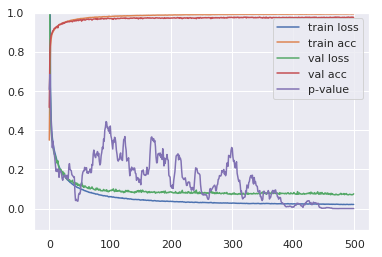

In [11]:
epochs = 500
for epoch in range(1, epochs + 1):
    #In the paper, evolutions occur on each epoch
    show_MNIST_connections(sparse_net)
    if epoch != 1:
        sparse_net.evolve_connections()
    set_history = train(log_interval, sparse_net, device, train_loader, optimizer, epoch, set_history)
    #And smallest connections are removed during inference.
    sparse_net.zero_connections()
    set_history = test(sparse_net, device, test_loader, set_history)
    set_history.plot()

In [12]:
set_history = test(sparse_net, device, test_loader, set_history)


Test set: Average loss: 0.0757, Accuracy: 9772/10000 (98%)



## Node Connections Solution
SET provides an elegant search algorithm for optimizing the connections between nodes. To demonstrate this, we can look at the number of connections per input pixel on the MNIST data.

While the effect isn't super obvious yet, more connections start to appear in the center of the pixel map over many epochs. The researchers show in the paper that after 150 epochs, and especially after 5000 epochs, there is a clear preferences for those pixels where the handwritten digits appear (in the center of the input images).<br><br>
From the paper:<img src='pixel_connections.png'>

One problem, if you look closely, is that the algorithm takes many, many epochs to find an optimal connection solution. The choice to reset connections every epoch makes the search frequency depend on the size of the dataset.<br><br>
One of the reasons I wanted to build this library was to experiment with other ways to apply this idea; PyTorch makes it easy.

## Evolving Connections with an Alternative Search Mechanism
An alternative idea would be to reset connections for each layer with some probability on each pass. The following is a quick experiment of this idea:

In [13]:
class EvolNet(nn.Module):
    """
    Resets connections with weighted coin toss on
    each forward pass
    """
    def __init__(self, evolution_proba=.05):
        super(EvolNet, self).__init__()
        self.set_layers = []
        self.set1 = SETLayer(784, 512)
        self.set_layers.append(self.set1)
        self.set2 = SETLayer(512, 128)
        self.set_layers.append(self.set2)
        #divide probability by the number of set layers.
        self.evolution_proba = evolution_proba/len(self.set_layers)
        self.fc1 = nn.Linear(128, 10)
        
    def zero_connections(self):
        """Sets connections to zero for inferences."""
        for layer in self.set_layers:
            layer.zero_connections()
        
    def evolve_connections(self):
        """Evolves connections."""
        for layer in self.set_layers:
            layer.evolve_connections()
            
    def sample_evolutions(self):
        """
        Each layer will evolve connections with
        self.evolution_proba likelihood.
        """
        for layer in self.set_layers:
            #Flip a weighted coin to evolve connections.
            if torch.rand(1) < self.evolution_proba:
                layer.evolve_connections()
        
    def forward(self, x):
        #Chance to evolve connections on each training pass.
        if self.training:
            self.sample_evolutions()
        x = x.reshape(-1, 784)
        x = F.relu(self.set1(x))
        x = F.relu(self.set2(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

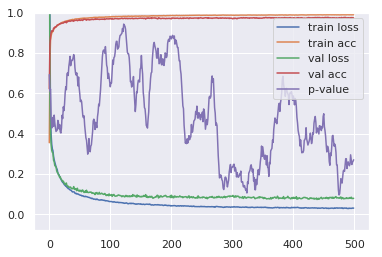

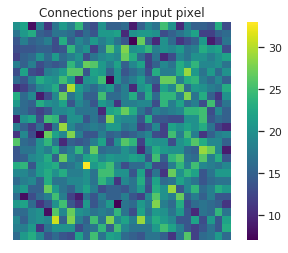

In [14]:
evol_net = EvolNet(evolution_proba=.2).to(device)
print('number of params: ', count_params(sparse_net))

optimizer = optim.SGD(evol_net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

evolnet_history = History()

for epoch in range(1, epochs + 1):
    evolnet_history = train(log_interval, evol_net, device, train_loader, optimizer, epoch, evolnet_history)
    evolnet_history = test(evol_net, device, test_loader, evolnet_history)
    evolnet_history.plot()
    show_MNIST_connections(evol_net)

This algorithm consistently shows stable convergence, converges slightly faster in terms of supervised objective loss, and appears to learn a network topology solution faster as well.

In [15]:
from scipy.stats import chisquare

In [16]:
vec = sparse_net.set1.connections[:, 0]
vec = np.array(vec)
_, counts = np.unique(vec, return_counts=True)
f_obs = counts
chisquare(f_obs)[1]

2.975539612351204e-06

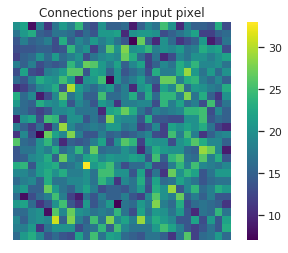

In [17]:
show_MNIST_connections(evol_net)

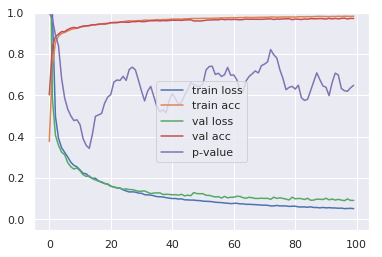

Train Epoch: 101 [0/60000 (0%)]	Loss: 0.030194
Train Epoch: 101 [8192/60000 (14%)]	Loss: 0.039383
Train Epoch: 101 [16384/60000 (27%)]	Loss: 0.047205
Train Epoch: 101 [24576/60000 (41%)]	Loss: 0.052771
Train Epoch: 101 [32768/60000 (54%)]	Loss: 0.041035


KeyboardInterrupt: 

In [18]:
evol_net = EvolNet(evolution_proba=.2).to(device)
print('number of params: ', count_params(sparse_net))

optimizer = optim.SGD(evol_net.parameters(), lr=lr, momentum=momentum)

evolnet_history = History()

for epoch in range(1, epochs + 1):
    evolnet_history = train(log_interval, evol_net, device, train_loader, optimizer, epoch, evolnet_history)
    evolnet_history = test(evol_net, device, test_loader, evolnet_history)
    evolnet_history.plot()
    
evolnet_history = test(evol_net, device, test_loader, evolnet_history)
    
show_MNIST_connections(evol_net)

In [ ]:
evolnet_history.val_loss.pop(0)

In [ ]:
epochs = 500

for epoch in range(1, epochs + 1):
    show_MNIST_connections(evol_net)
    evolnet_history = train(log_interval, evol_net, device, train_loader, optimizer, epoch, evolnet_history)
    evolnet_history = test(evol_net, device, test_loader, evolnet_history)
    evolnet_history.plot()
    
evolnet_history = test(evol_net, device, test_loader, evolnet_history)
    
show_MNIST_connections(evol_net)

In [ ]:
keys = [key for key in optimizer.state.keys()]
zeros = torch.zeros([2])
inds = torch.tensor([0, 2]).long()
optimizer.state[keys[0]]['momentum_buffer'][inds] = zeros
optimizer.state[keys[0]]['momentum_buffer']

In [ ]:
another_optimizer = optim.SGD(evol_net.parameters(), lr=lr, momentum=momentum)
another_optimizer.state_dict()

## Experiment!
This software is here to encourage experiments! I hope to see curious deep learners use the synapses library to create cool things; and I REALLY hope this inspires contributors to step in and optimize this promising algorithm!